In [ ]:
%reload_ext autoreload
%autoreload 2
from alignment.alignment import Alignment
import pandas as pd
from utils.path import WildcardPath
from alignment.ensemble import Ensemble
from alignment.dataset import Dataset
from features.pairwise import Metric

import numpy as np

DATA_DIR = WildcardPath("/hits/fast/cme/bodynems/data/")
RESULT_DIR = WildcardPath("/hits/fast/cme/bodynems/MSA_difficulty/results")

BENCHMARKS = ["treebase_testing", "balibase3/RV11", "balibase3/RV12"]
INPUT_DIR = DATA_DIR / "input" / "{benchmark}"
OUTPUT_DIR = DATA_DIR / "output" / "{benchmark}"

DATASET_DIR = OUTPUT_DIR / "{dataset}"

MUSCLE5_DIR = DATASET_DIR / "Muscle5"

muscle_msas = []
benchmark = BENCHMARKS[0]
# dataset_name = OUTPUT_DIR.format(benchmark=benchmark).listdir(dirs_only=True)[0]
dataset_name = "11939_0.phy"
dataset = Dataset(
    DATASET_DIR.format(benchmark=benchmark, dataset=dataset_name)
    / "sequences.fasta"
)
for idx in range(4):
    # for prefix in ["none", "abc", "acb", "bca"]:
    for prefix in ["none"]:
        msa_file = (
            MUSCLE5_DIR.format(benchmark=benchmark, dataset=dataset_name)
            / f"{prefix}.{idx}.msa.fasta"
        )
        muscle_msas.append(Alignment(msa_file, data_type=dataset.data_type))

ensemble = Ensemble(list(muscle_msas), dataset=dataset)


In [15]:
import features.unaligned

# metal = WilcardPath("/hits/fast/cme/bodynems/tools/metal")
extractor = features.unaligned.DatasetFeatureExtractor(dataset, threads=8)
aligned_features = extractor.compute()

: 

: 

In [18]:
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
import features.encoding
from utils.enums import PositionalEncodingEnum

test = np.array(
    [
        ["a", "c", "a", "-", "-", "t"],
        ["-", "g", "-", "c", "c", "t"],
        ["a", "c", "-", "c", "g", "-"],
    ]
)
test = np.vectorize(str.upper)(test)

# pd.DataFrame(test).apply(str.upper).to_numpy()

encodings = [
    PositionalEncodingEnum.UNIFORM,
    PositionalEncodingEnum.SEQUENCE,
    PositionalEncodingEnum.POSITION,
]
pretty_names = [
    r"$\text{d}_\text{SSP}$",
    r"$\text{d}_\text{seq}$",
    r"$\text{d}_\text{pos}$",
]
seq_idxs = [r"$\mathbf{S}_1~~~~~~$", r"$\mathbf{S}_2~~~~~~$", r"$\mathbf{S}_3~~~~~~$"]
codes = []
for encoding, name in zip(encodings, pretty_names):
    coded = features.encoding.encode_positions(test, 3, encoding=encoding)

    for code in coded:
        codes.append(code)

og = []
for line in test:
    og.append(line)
codes = og + codes

pretty_names = [r"$\mathbf{\Omega}_\text{DNA}$"] + pretty_names
idx = pd.MultiIndex.from_arrays((np.repeat(pretty_names, 3), np.tile(seq_idxs, 4)))

codes_df = pd.DataFrame(codes, index=idx, columns=np.arange(1, 7), dtype="string")
codes_df[codes_df == "-1"] = r"\cellcolor{blue!10}"
neg_mask = codes_df.map(lambda s: s.startswith("-"))
codes_df[neg_mask] = "\cellcolor{blue!10}" + codes_df[neg_mask]
codes_df[~neg_mask] = "\cellcolor{pink!15}" + codes_df[~neg_mask]

print(
    codes_df.to_latex(
        index=True,
        # formatters={"name": str.upper},
        # float_format="{:.1f}".format,
    )
)

\begin{tabular}{llllllll}
\toprule
 &  & 1 & 2 & 3 & 4 & 5 & 6 \\
\midrule
\multirow[t]{3}{*}{$\mathbf{\Omega}_\text{DNA}$} & $\mathbf{S}_1~~~~~~$ & \cellcolor{pink!15}A & \cellcolor{pink!15}C & \cellcolor{pink!15}A & \cellcolor{blue!10}- & \cellcolor{blue!10}- & \cellcolor{pink!15}T \\
 & $\mathbf{S}_2~~~~~~$ & \cellcolor{blue!10}- & \cellcolor{pink!15}G & \cellcolor{blue!10}- & \cellcolor{pink!15}C & \cellcolor{pink!15}C & \cellcolor{pink!15}T \\
 & $\mathbf{S}_3~~~~~~$ & \cellcolor{pink!15}A & \cellcolor{pink!15}C & \cellcolor{blue!10}- & \cellcolor{pink!15}C & \cellcolor{pink!15}G & \cellcolor{blue!10}- \\
\cline{1-8}
\multirow[t]{3}{*}{$\text{d}_\text{SSP}$} & $\mathbf{S}_1~~~~~~$ & \cellcolor{pink!15}11 & \cellcolor{pink!15}12 & \cellcolor{pink!15}13 & \cellcolor{pink!15}\cellcolor{blue!10} & \cellcolor{pink!15}\cellcolor{blue!10} & \cellcolor{pink!15}14 \\
 & $\mathbf{S}_2~~~~~~$ & \cellcolor{pink!15}\cellcolor{blue!10} & \cellcolor{pink!15}21 & \cellcolor{pink!15}\cellcolor{blu

In [ ]:
from features.pairwise import (
    SSPDistance as Metric_ref,
    HomologySeqDistance as Metric_alt,
)
import itertools
from tqdm import tqdm
from time import time


def compute_metrics(ensemble, metric_ref, metric_alt):
    dists_ref = []
    dists_alt = []

    for al_x, al_y in tqdm(list(itertools.combinations(ensemble.ensemble, r=2))):
        start = time()
        # print(len(al_x.msa[0]), len(al_y.msa[0]))
        seq_dist = metric_ref.compute(al_x, al_y)
        print("ref:", time() - start)
        seq_dist_alt = metric_alt.compute(al_x, al_y)
        print("alt:", time() - start)
        dists_ref.append(seq_dist)
        dists_alt.append(seq_dist_alt)
    dists_ref = np.array(dists_ref)
    dists_alt = np.array(dists_alt)

    dist_df = pd.DataFrame([dists_ref, dists_alt]).T
    dist_df.columns = ["ref", "alt"]
    return dist_df


metric_ref = Metric_ref()
metric_alt = Metric_alt()
dist_df = compute_metrics(ensemble, metric_ref, metric_alt)
dist_df.describe()

In [38]:
import features.aligned

# metal = WilcardPath("/hits/fast/cme/bodynems/tools/metal")
extractor = features.aligned.EnsembleFeatureExtractor(
    ensemble,
    dataset,
    None,
    None,
    None,
    None,
    compute_distance_matrix=True,
    threads=8,
    verbose=True,
)
aligned_features = extractor.compute([extractor._cc_lc_dispersion])

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

symmetrized_sp_dist : 0.39955830574035645s
homology_seq_dist : 0.2322420279184977s
homology_pos_dist : 0.23297015825907388s
homology_raw_dist : 0.2643507719039917s
gap_delta_dist : 0.06964488824208577s
displacement_dist : 0.06342037518819173s
displacement_dist_d0 : 0.052539308865865074s
displacement_dist_d1 : 0.052784085273742676s
displacement_dist_d2 : 0.05402255058288574s
displacement_dist_d4 : 0.05359208583831787s
displacement_dist_d8 : 0.051894307136535645s
displacement_dist_d16 : 0.05358290672302246s
displacement_dist_d32 : 0.05357666810353597s
perc_hash_hamming_dist_16bit : 0.2598044474919637s
perc_hash_hamming_dist_64bit : 0.2604084412256877s
perc_hash_hamming_dist_256bit : 0.2640097935994466s


<Axes: >

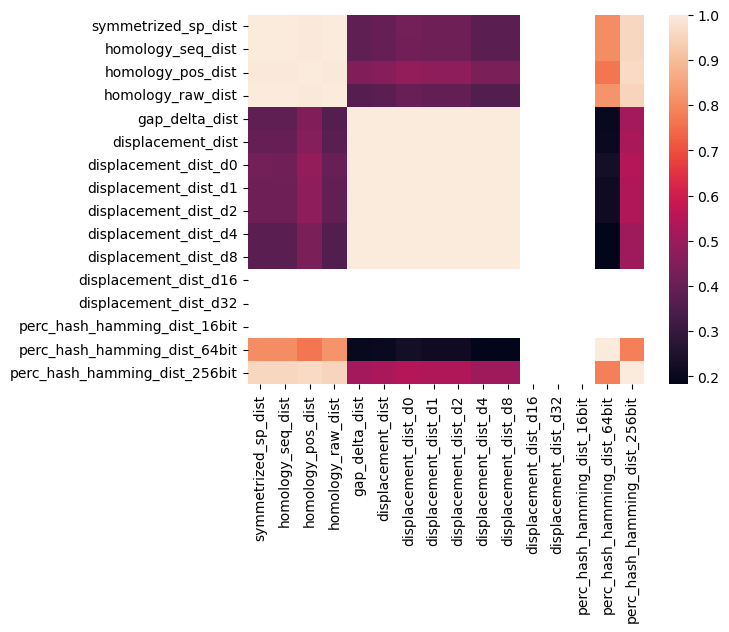

In [40]:
import seaborn as sn

dists_ref = {}
for name, dist_mat in extractor._dist_mat_dict.items():
    dists_ref[name] = np.concatenate([arr for arr in dist_mat.to_numpy()])

dist_df = pd.DataFrame(dists_ref)
sn.heatmap(dist_df.corr(), annot=False, fmt=".2f")
# dist_df.describe()

In [117]:
%autoreload 2
import features.pairwise
import itertools
from features.aligned import EnsembleFeatureExtractor
from utils.enums import FeatureEnum as FE
import seaborn as sn
import time 
import tempfile
from Bio import AlignIO

thresholds = [1, 4, 10, 22, 46]
weights = [1] * len(thresholds)

metrics = features.pairwise._CUSTOM_METRICS
names = [metric.name for metric in metrics]


results = {name: [] for name in names}
for idx_x, idx_y in itertools.combinations(range(len(ensemble.ensemble)), r=2):
    A_x, A_y = ensemble.ensemble[idx_x], ensemble.ensemble[idx_y]
    for name, metric_ref in zip(names, metrics):
        start = time.time()
        results[name].append(metric_ref.compute(A_x, A_y))
        end = time.time()
        if metric_ref.enum == FE.PERC_HASH_HAMMING:
            print(f"{end-start:.4f}: {name}")
dist_df = pd.DataFrame(results)

for i in range(len(ensemble.ensemble)):
    ensemble.ensemble[i].tool = "Muscle1"

# dist_df.describe().round(2)
# dist_df.corr().round(2)
# sn.heatmap(dist_df.corr() > 0.999, fmt=".0%")

In [14]:
# TODO: Write code for homology set metrics (put indices into MSA array):
# d_SSP --> gaps = None, d_seq --> multiple gaps with same index, d_pos --> every gap with unique index (?)

In [5]:
def map_site_vals_to_alignment(sites: list, alignment: Alignment):
    site_mapping = np.empty_like(alignment.msa)
    if len(sites) != len(site_mapping):
        raise ValueError(f"Found {len(sites)} in sites but {len(site_mapping)} in MSA.")
    for seq in sites:
        pass